<a href="https://colab.research.google.com/github/ChrisHarvey21/HABs/blob/main/HABs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PART ONE: DATA DOWNLOAD & PRE-PROCESS CODE**

## **The first section of this code has three parts.  1. Installation of neccessary packages. 2. downloading of data from online sources(written description). 3. Processing of downloaded data to get it into model-ready form.**

In [684]:
#Part 1. Packages installation
%%capture
!pip install geopandas
!pip install libpysal

In [685]:
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from numpy import mean
from numpy import std
from numpy import absolute
from libpysal.weights.contiguity import Queen
import libpysal
from statsmodels.api import OLS
sns.set_style('white')

In [686]:
#attach to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [687]:
#Part 2. Data download
#Load in Dataset
#Data from NYSDEC website at url "https://nysdec.maps.arcgis.com/apps/webappviewer/index.html?id=692b72ae03f14508a0de97488e142ae1"
#To downlaod the data first select HABs status
#Next filter by your lake of interest.  Skaneateles Lake ID code is 0707SKA0193
#Finally click options and export to CSV
#The link below imports the data from the described above downlaoded CSV.

url = 'https://raw.githubusercontent.com/ChrisHarvey21/HABs/main/Lakes_%20HABs%20Status.csv'

df1 = pd.read_csv(url)


In [688]:
#Obtain Precipitation and Temperature Data
#The site used for data gathering is "http://climod2.nrcc.cornell.edu/"
#Next proceed to the heading "product selection" and choose "single station" and "Daily Data Listing"
#Next click on the tab Options Selections and choose HTML, the range of dates, and the parameters you want.
#For this script I chose HTML, 2016-11-01 to 2022-11-03, max temp, min temp, average temp, and precipitation
#Lastly choose your location. I selected Syracuse Hancock Airport
#Click Go
#To download the data I copy and pasted the data into an excel csv file.  I then uploaded it to github
#The code below imports this data

url2 = 'https://raw.githubusercontent.com/ChrisHarvey21/HABs/main/precip.csv'

df2 = pd.read_csv(url2)

In [689]:
#Part 3: Data Processing to get it in proper format

#Remove dates with no HABs
df1 = df1.dropna(subset=['HS_HAB_STATUS_DATE'])

#Remove uneeded columns
df1.drop(['LOCATION_ID', 'SAMPLE_TIME','DATA_PROVIDER', 'HFD_EXTENT','INFORMATION_TYPE'], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [690]:
#Split Data and Time in df1 so we can combine datasets based on time
df1['Date'] = pd.to_datetime(df1['HS_HAB_STATUS_DATE']).dt.date
df1['Time'] = pd.to_datetime(df1['HS_HAB_STATUS_DATE']).dt.time

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [691]:
#clean data
df1['Date'] = pd.to_datetime(df1.Date)
df1.info()

#Check for duplicates
df1.nunique()

#remove duplicates
df1.drop_duplicates(subset=['Date'], keep=False, inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 28 to 712
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   LAKE_ID             100 non-null    object        
 1   LOCATION_TYPE       100 non-null    object        
 2   HS_HAB_STATUS       100 non-null    object        
 3   HS_HAB_STATUS_DATE  100 non-null    object        
 4   Date                100 non-null    datetime64[ns]
 5   Time                100 non-null    object        
dtypes: datetime64[ns](1), object(5)
memory usage: 5.5+ KB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [692]:
#dataframe one reset index
df1 = pd.DataFrame(df1)
df1.reset_index()

,index,LAKE_ID,LOCATION_TYPE,HS_HAB_STATUS,HS_HAB_STATUS_DATE,Date,Time
0,28,0707SKA0193,SHORE,CONFIRMED WITH HIGH TOXINS,"10/4/2018, 8:00 PM",2018-10-04,20:00:00
1,29,0707SKA0193,SHORE,CONFIRMED,"9/18/2018, 8:00 PM",2018-09-18,20:00:00
2,51,0707SKA0193,SHORE,CONFIRMED,"9/8/2020, 8:00 PM",2020-09-08,20:00:00
3,351,0707SKA0193,SHORE,CONFIRMED WITH HIGH TOXINS,"8/16/2018, 8:00 PM",2018-08-16,20:00:00
4,352,0707SKA0193,SHORE,CONFIRMED,"8/8/2018, 8:00 PM",2018-08-08,20:00:00
5,353,0707SKA0193,SHORE,CONFIRMED,"9/4/2018, 8:00 PM",2018-09-04,20:00:00
6,354,0707SKA0193,SHORE,CONFIRMED WITH HIGH TOXINS,"9/6/2018, 8:00 PM",2018-09-06,20:00:00
7,356,0707SKA0193,SHORE,CONFIRMED,"9/27/2018, 8:00 PM",2018-09-27,20:00:00
8,358,0707SKA0193,SHORE,CONFIRMED,"10/8/2018, 8:00 PM",2018-10-08,20:00:00
9,372,0707SKA0193,SHORE,SUSPICIOUS,"9/8/2019, 8:00 PM",2019-09-08,20:00:00


In [693]:
#change the date type of data set 2 so both can be merged together
df2['Date'] = pd.to_datetime(df2.Date)
df2['Date1'] = pd.to_datetime(df2.Date)
df2['Date2'] = pd.to_datetime(df2.Date)

#Replace nonnumeric values with NaN
df2 = df2.replace('M', np.nan)
df2 = df2.replace('T', np.nan)
df2 = pd.DataFrame(df2)
df2.reset_index

<bound method DataFrame.reset_index of            Date Max_Temp Min_Temp Avg_Temp Precip      Date1      Date2
0    2016-11-01       60       28       44      0 2016-11-01 2016-11-01
1    2016-11-02       61       45       53   0.19 2016-11-02 2016-11-02
2    2016-11-03       56       47     51.5   0.65 2016-11-03 2016-11-03
3    2016-11-04       49       37       43   0.02 2016-11-04 2016-11-04
4    2016-11-05       58       44       51      0 2016-11-05 2016-11-05
...         ...      ...      ...      ...    ...        ...        ...
2189 2022-10-30       68       30       49      0 2022-10-30 2022-10-30
2190 2022-10-31       64       39     51.5    NaN 2022-10-31 2022-10-31
2191 2022-11-01       67       49       58    NaN 2022-11-01 2022-11-01
2192 2022-11-02       65       45       55      0 2022-11-02 2022-11-02
2193 2022-11-03      NaN      NaN      NaN    NaN 2022-11-03 2022-11-03

[2194 rows x 7 columns]>

In [694]:
#merge data sets together
merge = pd.merge(df1, df2, how='outer', on = 'Date')

In [695]:
#add new column for severity
merge['severity'] = np.nan

In [696]:
#Create new column with algal severity
merge.loc[merge['HS_HAB_STATUS'] == 'NO BLOOM', 'severity'] = '0'  
merge.loc[merge['HS_HAB_STATUS'] == 'CONFIRMED WITH HIGH TOXINS', 'severity'] = '3'  
merge.loc[merge['HS_HAB_STATUS'] == 'CONFIRMED', 'severity'] = '2'  
merge.loc[merge['HS_HAB_STATUS'] == 'SUSPICIOUS', 'severity'] = '1'  

In [697]:
#Add one/two day before date to dataframe
merge['Date1'] = merge['Date'] + pd.Timedelta(days=-1)
merge['Date2'] = merge['Date'] + pd.Timedelta(days=-2)

In [698]:
#Remove all columns from df2 expcept date and precipitation
df2.drop(['Max_Temp', 'Min_Temp','Avg_Temp'], axis=1, inplace=True)


In [699]:
#Create two seperate pandas to use
df3 = df2.copy()
df4 = df2.copy()

In [700]:
#Remove columns not needed in each
df3.drop(['Date', 'Date2'], axis=1, inplace=True)
df4.drop(['Date', 'Date1'], axis=1, inplace=True)

In [701]:
#Rename columns
df3 = df3.rename(columns={'Precip': 'Precip1'})
df4 = df4.rename(columns={'Precip': 'Precip2'})

In [702]:
#Merge df2 together based on the first subtracted date
#dataframe one reset index
merge = pd.DataFrame(merge)
merge.reset_index()

#change the date type of data set 2 so both can be merged together
df3['Date1'] = pd.to_datetime(df3.Date1)
df3 = pd.DataFrame(df3)
df3.reset_index

#merge together with Date 1
merge1 = pd.merge(merge, df3, how='outer', on = 'Date1')

In [703]:
#Repeat for second date range
merge1 = pd.DataFrame(merge1)
merge1.reset_index()

#change the date type of data set 2 so both can be merged together
df4['Date2'] = pd.to_datetime(df4.Date2)
df4 = pd.DataFrame(df4)
df4.reset_index

#merge together with Date 1
merge2 = pd.merge(merge1, df4, how='outer', on = 'Date2')

In [704]:
#Remove uneeded Columns
merge2.drop(['HS_HAB_STATUS_DATE', 'Time', 'Date1', 'Date2'], axis=1, inplace=True)


In [705]:
#Convert all numeric columns to numeric
merge2[['Precip', 'Precip1' , 'Precip2', 'Max_Temp','Min_Temp','Avg_Temp','severity']]  = merge2[['Precip','Precip1','Precip2', 'Max_Temp','Min_Temp','Avg_Temp','severity']].apply(pd.to_numeric)

#change NAN values to 0 for precipitation columns
merge2 = pd.DataFrame(merge2)
merge2[['Precip','Precip1','Precip2']] = merge2[['Precip','Precip1','Precip2']].fillna(0)

In [706]:
#Create 3-day sum precipiation column
merge2['PrecipSum'] = merge2['Precip'] + merge2['Precip1'] + merge2['Precip2']

In [707]:
#Clean up extra data from precipitation
final=merge2.dropna()
final=merge2.dropna(axis=0)
final.head()

,LAKE_ID,LOCATION_TYPE,HS_HAB_STATUS,Date,Max_Temp,Min_Temp,Avg_Temp,Precip,severity,Precip1,Precip2,PrecipSum
0,0707SKA0193,SHORE,CONFIRMED WITH HIGH TOXINS,2018-10-04,71.0,51.0,61.0,0.10,3.0,0.00,0.58,0.68
1,0707SKA0193,SHORE,CONFIRMED,2018-09-18,81.0,64.0,72.5,0.07,2.0,0.24,0.00,0.31
2,0707SKA0193,SHORE,CONFIRMED,2020-09-08,86.0,64.0,75.0,0.00,2.0,0.00,0.00,0.00
3,0707SKA0193,SHORE,CONFIRMED WITH HIGH TOXINS,2018-08-16,86.0,70.0,78.0,0.00,3.0,0.00,0.30,0.30
4,0707SKA0193,SHORE,CONFIRMED,2018-08-08,81.0,65.0,73.0,0.67,2.0,0.00,0.52,1.19


### **END OF DATA PROCESSING(Ignore rest of document for data processing assignment**

# **PART TWO: MODEL TRAIN AND VALIDATE CODE**

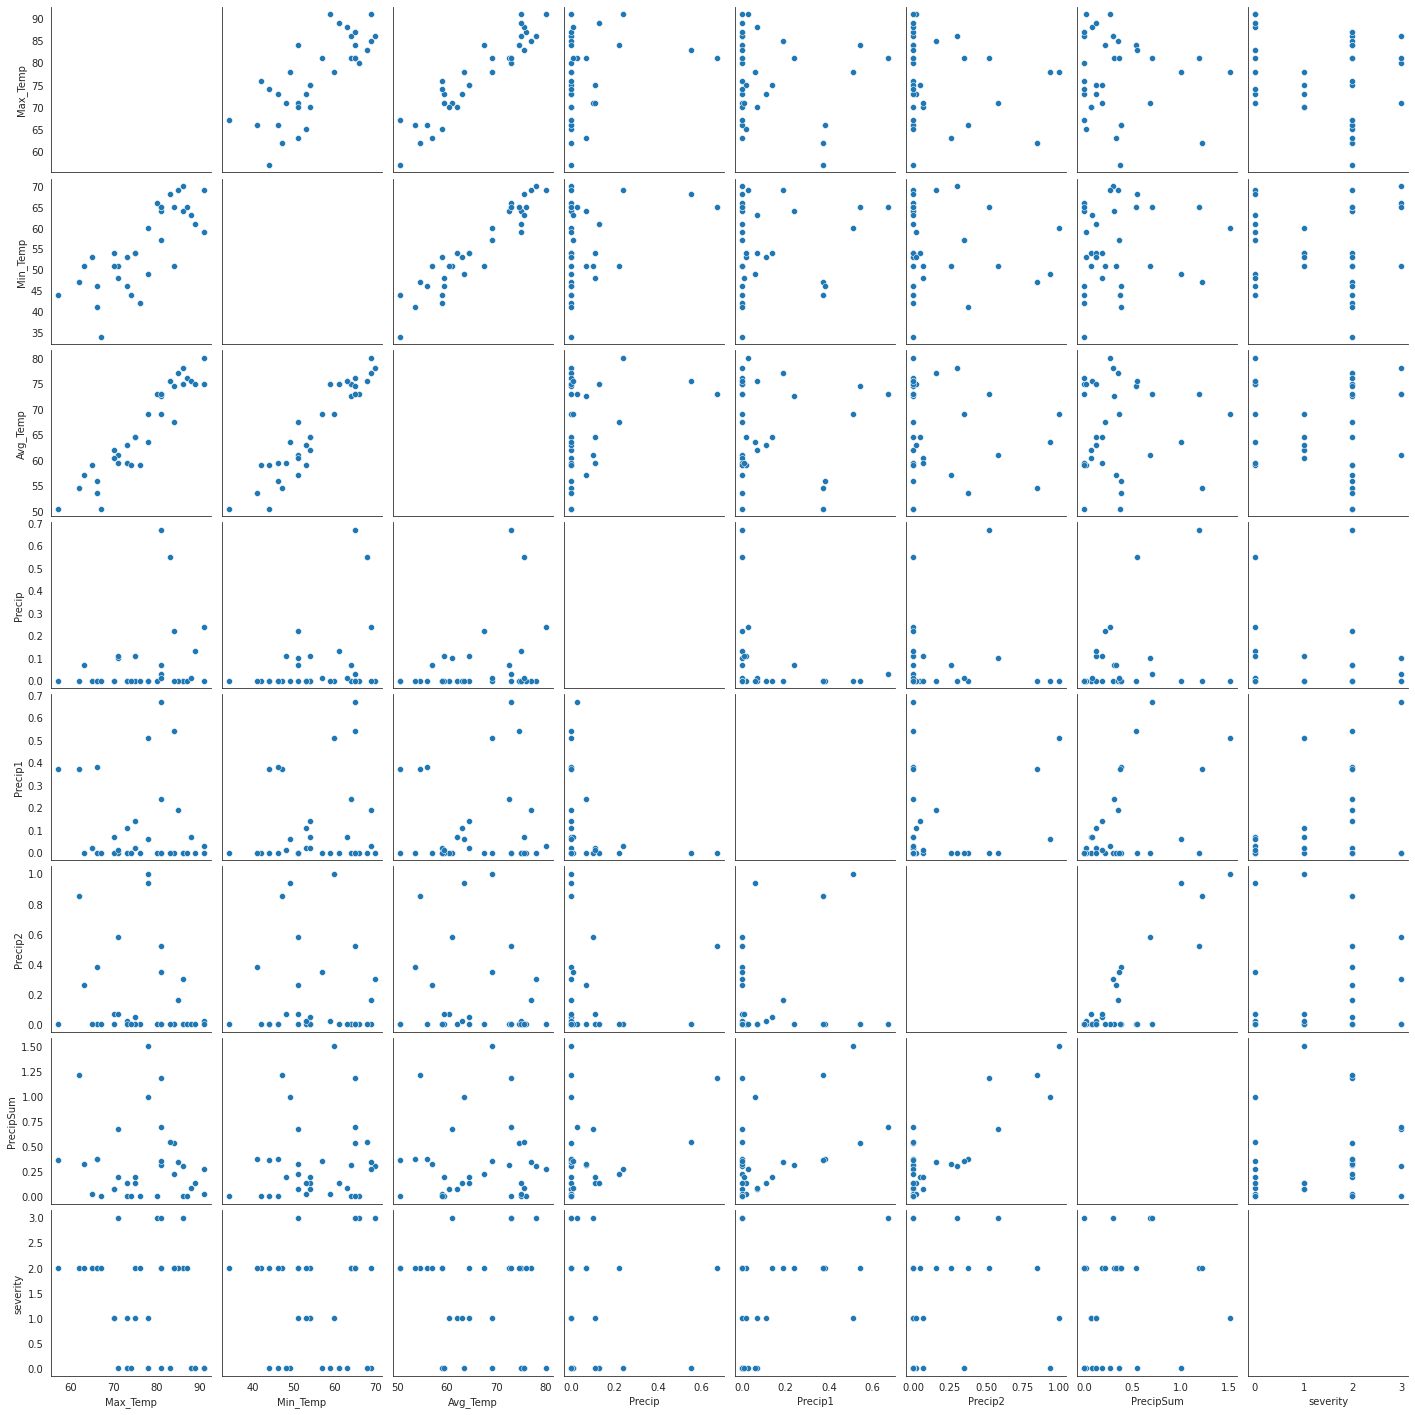

In [708]:
#Create a scatterplot to look for collinearity
#Create subset of habs called mylist
my_list = ["Date", "Max_Temp", "Min_Temp", "Avg_Temp" , "Precip", "Precip1", "Precip2","PrecipSum","severity"]    

#check to make sure all your columns are there:
final[my_list].head()

#Seaborn.pairplot to plot a scatterplot matrix
#sns.pairplot(final[my_list],diag_kind='')

#We can see there is colinearity between the max, min, and average temp and some between the precips and sum precip which is expected

In [709]:
#Do VIF, if any are greater than 10 we have to either throw out predictor variables that arent important or add on bias reducers
#Calculate VIFs on our dataset
my_list1 = ["Date", "Max_Temp", "Min_Temp", "Avg_Temp" , "Precip", "Precip1", "Precip2","PrecipSum"]    
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(final[my_list1[1:8]].values, i) for i in range(final[my_list1[1:8]].shape[1])]
vif["features"] = final[my_list1[1:8]].columns

vif.round()


/usr/local/lib/python3.7/dist-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF Factor,features
0,inf,Max_Temp
1,inf,Min_Temp
2,inf,Avg_Temp
3,inf,Precip
4,inf,Precip1
5,inf,Precip2
6,inf,PrecipSum


In [710]:
#Formulating a model

#extract the variable we want to use to predict algal severity
X = np.array(final[my_list1[1:8]].values)
#standardize data to assist in interpretation of coefficients
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

#extract variable that we want to "predict"
Y = np.array(final['severity'].values)
#standardize data to assist in interpretation of coefficients
Y = (Y - np.mean(X)) / np.std(Y)

lm = OLS(Y,X)
lm_results = OLS(Y,X).fit().summary()
print(lm_results)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.077
Model:                            OLS   Adj. R-squared (uncentered):             -0.077
Method:                 Least Squares   F-statistic:                             0.4996
Date:                Sat, 05 Nov 2022   Prob (F-statistic):                       0.774
Time:                        18:37:39   Log-Likelihood:                         -66.803
No. Observations:                  35   AIC:                                      143.6
Df Residuals:                      30   BIC:                                      151.4
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [711]:
#Random Forest Regression
# Import libraries
import numpy as np # for array operations
import pandas as pd # for working with DataFrames
import requests, io # for HTTP requests and I/O commands
import matplotlib.pyplot as plt # for data visualization
%matplotlib inline

# scikit-learn modules
from sklearn.model_selection import train_test_split # for splitting the data
from sklearn.metrics import mean_squared_error # for calculating the cost function
from sklearn.ensemble import RandomForestRegressor # for building the model

# Reading the data
#'Max_Temp','Min_Temp','Precip1','Precip2','PrecipSum'
dataset = final
dataset.drop(['LAKE_ID','LOCATION_TYPE','HS_HAB_STATUS','Date'], axis=1, inplace=True)
dataset.head()


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Max_Temp,Min_Temp,Avg_Temp,Precip,severity,Precip1,Precip2,PrecipSum
0,71.0,51.0,61.0,0.10,3.0,0.00,0.58,0.68
1,81.0,64.0,72.5,0.07,2.0,0.24,0.00,0.31
2,86.0,64.0,75.0,0.00,2.0,0.00,0.00,0.00
3,86.0,70.0,78.0,0.00,3.0,0.00,0.30,0.30
4,81.0,65.0,73.0,0.67,2.0,0.00,0.52,1.19


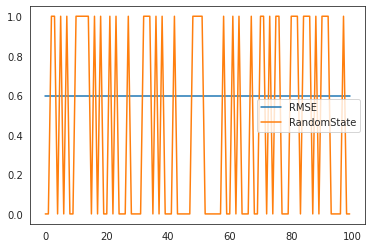

In [748]:
#Create features vs target
import pandas as pd
from random import randint

#create the data frame
df = pd.DataFrame(columns=['RMSE','RandomState'])
for i in range(100): 

  x = dataset.drop('severity', axis = 1) # Features
  y = dataset['severity']  # Target

# Splitting into training and testing (80/20)
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=20)

# Random Forest Regression with 10 decision trees
  model = RandomForestRegressor(n_estimators = 10, random_state=20)

# Fitting the Random Forest Regression model to the data
  model.fit(x_train, y_train) 

# Predicting the target values of the test set
  y_pred = model.predict(x_test)

# RMSE (Root Mean Square Error)
  rmse = float(format(np.sqrt(mean_squared_error(y_test, y_pred)),'.3f'))
  df.loc[i, ['RMSE']] = rmse
  df.loc[i, ['RandomState']] = randint(0,1)

#Plot results
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame(df)
df.plot()
plt.show()

In [733]:
#A rule of thumb is that an RMSE of .2 to .5 shows that the model predicts accurately
print('Mean', df.mean())
print('Max', df.max())
print('Min', df.min())

Mean RMSE    1.08623
dtype: float64
Max RMSE    1.668
dtype: object
Min RMSE    0.374
dtype: object


In [734]:
# Calculate the absolute errors
errors = abs(y_pred - y_test)
# Print out the mean absolute error (mae)
print('The average error between the predictions and actuals in this dataset is ', round(np.mean(errors), 2), 
      ', compared to the average severity which is' , round(np.mean(y),2))

The average error between the predictions and actuals in this dataset is  0.99 , compared to the average severity which is 1.4


# **PART THREE: FIGURES & VISUALIZATION**

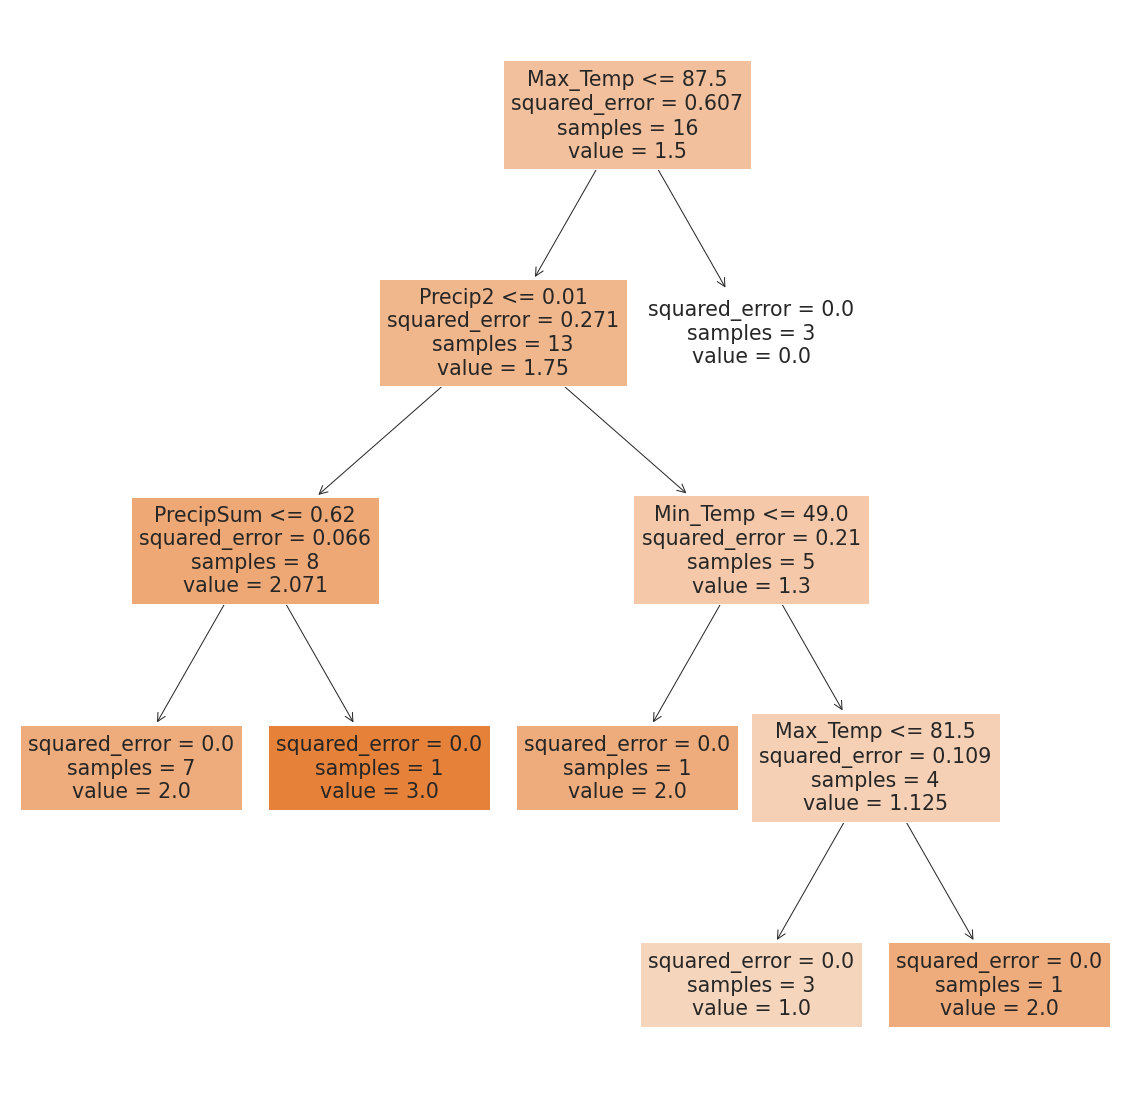

In [735]:
#Creation of a decision tree for random forest regression
class_names = ['Max_Temp', 'Min_Temp', 'Avg_Temp','Precip','Precip1','Precip2','PrecipSum']

plt.figure(figsize=(20,20))
_ = tree.plot_tree(model.estimators_[0], feature_names=class_names, filled=True)

In [797]:
df = pd.DataFrame(columns=['A','B'])
import random
A = randint(0,99)
print(A)
random.seed(A)
print(random.random())


for i in range(5): #add 5 rows of data
    random.seed(A)
    df.loc[i, ['A']] = random.random()
    random.seed(A)
    df.loc[i, ['B']] = random.random()

df


69
0.6842409524120733


,A,B
0,0.684241,0.684241
1,0.684241,0.684241
2,0.684241,0.684241
3,0.684241,0.684241
4,0.684241,0.684241


In [785]:
import random

A = randint(0,99)
A
random.seed(A)
random.random()

random.seed(A)
random.random()

0.9783548583709967

In [782]:
random.seed(A)
random.random()

0.20985124453651727

In [ ]:
#Create features vs target
import pandas as pd
from random import randint

#create the data frame
df = pd.DataFrame(columns=['RMSE'])
for i in range(500): #add 5 rows of data

  x = dataset.drop('severity', axis = 1) # Features
  y = dataset['severity']  # Target

# Splitting into training and testing (80/20)
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

# Random Forest Regression with 10 decision trees
  model = RandomForestRegressor(n_estimators = 10)

# Fitting the Random Forest Regression model to the data
  model.fit(x_train, y_train) 

# Predicting the target values of the test set
  y_pred = model.predict(x_test)

# RMSE (Root Mean Square Error)
  rmse = float(format(np.sqrt(mean_squared_error(y_test, y_pred)),'.3f'))
  df.loc[i, ['RMSE']] = rmse


#Plot results
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame(df)
df.plot()
plt.show()